In [1]:
####Linear Gaussian State Space model####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import calendar
import statsmodels
import statsmodels.api as sm
from datetime import datetime
from datetime import timedelta
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

np.random.seed(98537)

In [2]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, pattern):
    if pattern==1:
        z_id = np.array(np.argmax(np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis], axis=1), dtype="int")
        Z = np.diag(np.repeat(1, k))[z_id, ]
        return z_id, Z
    z_id = np.array(np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1), dtype="int")
    return z_id
    
#連続した日付を取得する関数
def daterange(_start, _end):
    for n in range((_end - _start).days):
        yield _start + timedelta(n)

In [3]:
####シミュレーションデータを生成####
##日付データを作成
#対象期間の日付と曜日情報を出力
start = datetime.strptime('2014-01-01', '%Y-%m-%d')
end   = datetime.strptime('2019-09-30', '%Y-%m-%d')
get_date = np.array([])
day_of_week = np.array([], dtype="int")
for day in daterange(start, end):
    get_date = np.append(get_date, day)
    day_of_week = np.append(day_of_week, day.weekday())
    
#日付を定義
Timestamp = pd.Series(get_date)
date = pd.DataFrame({"date": Timestamp.astype("U")})
date_df = pd.merge(date, pd.DataFrame({"date": np.unique(date), "date_id": np.arange(date.shape[0])}), on="date", how="inner")
year = pd.DataFrame({"year": Timestamp.astype("U").str[:4]})
unique_year = np.unique(year)
year_df = pd.merge(year, pd.DataFrame({"year": unique_year, "year_id": np.arange(unique_year.shape[0])}), on="year", how="inner")
month = pd.DataFrame({"month": Timestamp.astype("U").str[:7]})
unique_month = np.unique(month)
month_df = pd.merge(month, pd.DataFrame({"month": unique_month, "month_id": np.arange(unique_month.shape[0])}), on="month", how="inner")

#週を定義
freq = pd.Series(day_of_week).value_counts()
argmax_week = freq.index[np.argmax(np.array(freq))]
index = np.array(np.where(day_of_week==0)[0], dtype="int")
if np.min(index)!=0:
    index = np.append(0, index)
if np.max(index)!=day_of_week.shape[0]-1:
    index = np.append(index, day_of_week.shape[0])
weeks = index.shape[0] - 1
week = np.repeat(0, day_of_week.shape[0])
for i in range(weeks):
    if i==0:
        get = np.arange(index[i], index[i+1])
        week[get] = np.repeat(i, get.shape[0])
    else:
        get = np.arange(index[i], index[i+1])
        week[get] = np.repeat(i, get.shape[0])
        
#データフレームを作成
calendar_df = pd.concat((date_df[["date"]], year_df, month_df, pd.DataFrame({"week_id": week, "day_of_week": day_of_week})), axis=1)
calendar_df["month_index"] = calendar_df["month"].str[5:7].astype("int")

In [4]:
##データの生成
#データの定義
days = calendar_df["date"].shape[0]
weeks = np.unique(calendar_df["day_of_week"]).shape[0]
months = np.unique(calendar_df["month_index"]).shape[0]

In [17]:
#周期成分を生成
week = np.array(np.eye(weeks), dtype="int")[np.array(calendar_df["day_of_week"]), 1:]
month = np.array(np.eye(months), dtype="int")[np.array(calendar_df["month_index"])-1, 1:]
k = week.shape[1] + month.shape[1] + 1

In [28]:
##静的および動的パラメータを生成
#状態パラメータ
s = 5
S1 = np.array([0.05, 0.15, 0.6, 0.15, 0.05])
S2 = np.array([[0.82, 0.11, 0.06, 0.01, 0.01],
               [0.11, 0.79, 0.07, 0.02, 0.01],
               [0.01, 0.02, 0.95, 0.02, 0.01],
               [0.01, 0.02, 0.07, 0.79, 0.11],
               [0.01, 0.01, 0.06, 0.11, 0.82]])

#状態推移を生成
z = np.repeat(0, days)
for i in range(days):
    if i==0:
        z[i] = np.argmax(np.random.multinomial(1, S1, 1))
    else:
        z[i] = np.argmax(np.random.multinomial(1, S2[z[i-1], ], 1))
        
#初期値の設定
trend = np.repeat(0.0, days)
tau = np.array([0.01])

#時間ごとにパラメータを生成
for i in range(1, days):
    diff = np.sort(np.random.normal(0, tau, s))
    trend[i] = trend[i-1] + diff[z[i-1]]
    
#モデルパラメータを定義
beta_ar = np.array([0.3])
beta_week = np.random.normal(0, 0.2, weeks-1)
beta_month = np.random.normal(0, 0.2, months-1)
beta = np.append(np.append(beta_ar, beta_week), beta_month)
Sigma = np.array([0.3])
trendt = trend.copy(); betat = beta.copy(); Sigmat = Sigma.copy()

Text(0.5,1,'時系列をプロット')

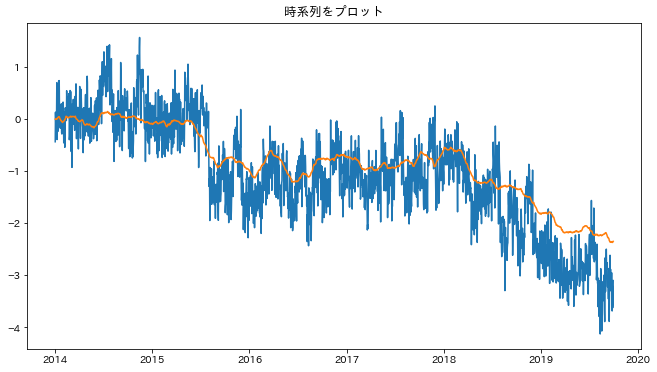

In [29]:
##応答変数を生成
#データの格納用配列
y = np.repeat(0.0, days)
Z = np.zeros((days, k))

for i in range(days):
    #入力を定義
    if i==0:
        Z[i, ] = np.append(np.append(0.0, week[i, ]), month[i, ])
    else:
        Z[i, ] = np.append(np.append(y[i-1], week[i, ]), month[i, ])

    #正規分布から時系列データを生成
    mu = trend[i] + np.dot(Z[i, ], beta)
    y[i] = mu + np.random.normal(0, Sigma, 1)
   
#時系列を可視化
fig = plt.figure(figsize=(11.0, 6.0))
plt.plot(pd.DataFrame(y, index=np.array(calendar_df["date"], dtype="datetime64[D]")))
plt.plot(pd.DataFrame(trend, index=np.array(calendar_df["date"], dtype="datetime64[D]")))
plt.title("時系列をプロット", fontsize=12.5)

In [30]:
####カルマンフィルターでパラメータを推定####
##カルマンフィルタを計算する関数
#カルマンフィルタを逐次計算する関数
def KF(beta, Sigma, y, Z, H, x, V, Q, F, G, days):
    
    #モデル誤差を定義
    er = y - np.dot(Z, beta)
    trend_days = np.repeat(0.0, days)
    VF_list = [i for i in range(days)]
    V_list = [i for i in range(days)]
    
    for i in range(days):
        #1期先予測
        Fx = np.dot(F, x)
        VF = np.dot(np.dot(F, V), F.T) + np.dot(np.dot(G, tau*Q), G.T)

        #フィルタリング
        index = np.array([i])
        HVH = np.dot(np.dot(H[index, ], VF), H[index, ].T) + np.power(Sigma, 2)
        inv_HVH = np.linalg.inv(HVH)
        K = np.dot(np.dot(VF, H[index, ].T), inv_HVH)   #カルマンゲイン
        new_x = x + np.dot(K, er[i] - np.dot(H[i, ], x)).reshape(-1)
        new_V = VF - np.dot(np.dot(K, H[index, ]), VF)

        #パラメータの更新
        x = new_x.copy()
        V = new_V.copy()
        trend_days[i] = x
        VF_list[i] = VF
        V_list[i] = new_V
    return trend_days, VF_list, V_list

#カルマンフィルタの対数尤度
def loglike(beta, Sigma, y, Z, H, x, V, Q, F, G, days):

    #モデル誤差を定義
    trend_days = np.repeat(0.0, days)
    Kal = np.repeat(0.0, days)
    er = y - np.dot(Z, beta)

    for i in range(days):
        #1期先予測
        Fx = np.dot(F, x)
        VF = np.dot(np.dot(F, V), F.T) + np.dot(np.dot(G, tau*Q), G.T)

        #フィルタリング
        index = np.array([i])
        HVH = np.dot(np.dot(H[index, ], VF), H[index, ].T) + np.power(Sigma, 2)
        inv_HVH = np.linalg.inv(HVH)
        K = np.dot(np.dot(VF, H[index, ].T), inv_HVH)   #カルマンゲイン
        new_x = x + np.dot(K, er[i] - np.dot(H[i, ], x)).reshape(-1)
        new_V = VF - np.dot(np.dot(K, H[index, ]), VF)

        #パラメータの更新
        x = new_x.copy()
        V = new_V.copy()
        trend_days[i] = x
        mu = x + np.dot(Z[i, ], beta)
        Kal[i] = np.log(np.linalg.det(HVH)) + np.dot(np.dot(y[i] - mu, inv_HVH), y[i] - mu)

    #対数尤度の和
    Lho = -1/2 * (days*np.log(2*np.pi) + np.sum(Kal))
    return -Lho

In [31]:
##静的パラメータの初期値を設定
#3次回帰のパラメータを推定
d = np.array(np.arange(days)/days)[:, np.newaxis]
D = np.hstack((np.repeat(1.0, days)[:, np.newaxis], d, np.power(d, 2), np.power(d, 3), 
               np.append(0, y[:days-1])[:, np.newaxis], week, month))
xy = np.dot(D.T, y)
inv_xx = np.linalg.inv(np.dot(D.T, D))
theta = np.dot(inv_xx, xy)

#静的パラメータを定義
beta = theta[4:]
Sigma = np.sqrt(np.sum(np.power(y - np.dot(D, theta), 2)) / days)
tau = np.array([0.01])

In [32]:
##準ニュートン法で静的パラメータを推定
#動的パラメータの初期値
par = 1   #システムモデルのパラメータ数
trend = np.mean(y[:10])   
tau = 0.01

#システムモデルの設定
x = np.array([trend])
V = np.diag(np.repeat(tau, par))
Q = np.diag(np.repeat(1.0, par))
F = np.diag(np.repeat(1.0, par))
G = np.diag(np.repeat(1.0, par))
H = np.repeat(1.0, days)[:, np.newaxis]

#対数尤度を最大化
res = optimize.minimize(loglike, beta, method="BFGS", args=(Sigma, y, Z, H, x, V, Q, F, G, days), options={"disp": True})
beta = res.x

#モデル誤差のパラメータを更新
trend = KF(beta, Sigma, y, Z, H, x, V, Q, F, G, days)[0]
mu = trend + np.dot(Z, beta)
Sigma = np.sqrt(np.sum(np.power(y - mu, 2)) / days)

         Current function value: 358.734565
         Iterations: 27
         Function evaluations: 821
         Gradient evaluations: 41


In [48]:
##固定区間平滑化でパラメータを平滑化
#動的パラメータの初期値
par = 1   #システムモデルのパラメータ数
x = np.array([trend[0]])
trend = KF(beta, Sigma, y, Z, H, x, V, Q, F, G, days)[0]
tau = 0.001

#システムモデルの設定
x = np.array([trend[0]])
V = np.diag(np.repeat(tau, par))
Q = np.diag(np.repeat(1.0, par))
F = np.diag(np.repeat(1.0, par))
G = np.diag(np.repeat(1.0, par))
H = np.repeat(1.0, days)[:, np.newaxis]

#1期先予測とフィルタリングで動的パラメータを更新
res = KF(beta, Sigma, y, Z, H, x, V, Q, F, G, days)
trend = res[0]
VF_list = res[1]
V_list = res[2]

#初期値を定義
new_trend = np.append(np.repeat(0.0, days-1), trend[days-1])
new_V = [i for i in range(days)]
new_V[days-1] = VF_list[days-1]

#固定区間平滑化でパラメータを更新
for i in np.arange(days-1)[::-1]:
    A = np.dot(np.dot(V_list[i], F), np.linalg.inv(VF_list[i]))
    new_trend[i] = trend[i] + np.dot(A, new_trend[i+1] - np.dot(F, trend[i]))
    new_V[i] = V_list[i] + np.dot(np.dot(A, new_V[i+1] - V_list[i]), A.T)

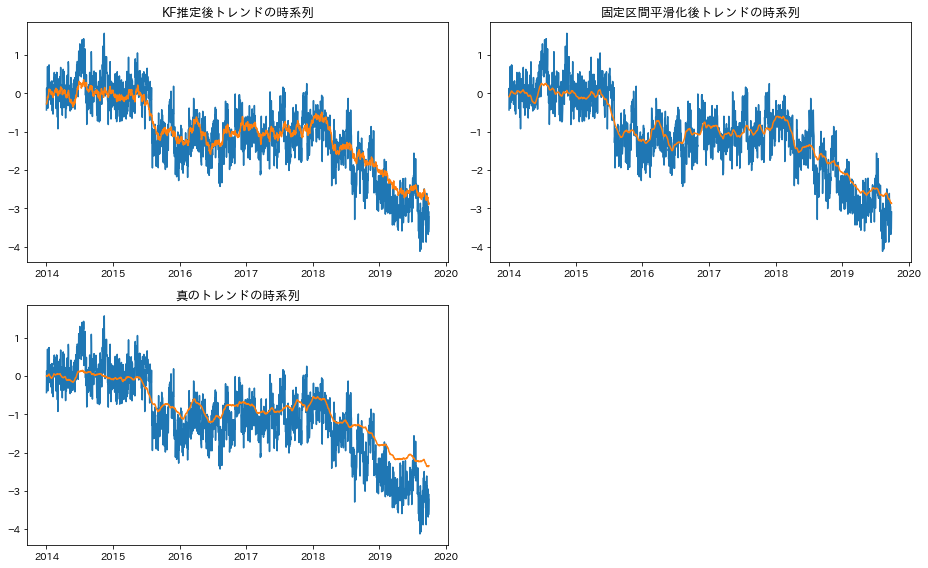

In [49]:
#生成したデータのヒストグラム
observed = pd.DataFrame({"観測値": y}, index= np.array(date["date"], dtype="datetime64[D]"))
trend_list = [pd.DataFrame({"trendの推定値": trend}, index= np.array(date["date"], dtype="datetime64[D]")),
              pd.DataFrame({"trendの平滑化推定値": new_trend}, index= np.array(date["date"], dtype="datetime64[D]")),
              pd.DataFrame({"trendの真値": trendt}, index= np.array(date["date"], dtype="datetime64[D]"))]
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["KF推定後トレンドの時系列", "固定区間平滑化後トレンドの時系列", "真のトレンドの時系列"]
fig = plt.figure(figsize=(13.0, 8.0))
for j in range(len(trend_list)):
    ax = fig.add_subplot(2, 2, j+1)
    plt.plot(observed)
    plt.plot(trend_list[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [50]:
np.sqrt(tau)

0.03162277660168379

In [52]:
np.sqrt(0.0001)

0.01